In [1]:
from __future__ import print_function
# standard packages
import numpy as np
import mdtraj as md
import pandas as pd
import math
import random
import time

import matplotlib.pyplot as plt

# OpenMM
from simtk.openmm import app
import simtk.unit as unit

# OpenMMTools
import openmmtools as omt

# OpenPathSampling
import openpathsampling as paths
from openpathsampling.tools import refresh_output

# Visualization of PathTrees
import openpathsampling.visualize as ops_vis
#from openpathsampling.visualize import PathTree
from IPython.display import SVG

# the openpathsampling OpenMM engine
import openpathsampling.engines.openmm as eng

# always the most complicated bit
import openpathsampling.engines.toy as toys
%run toy_plot_helpers_Z.py

from datetime import datetime

import pickle

np.set_printoptions(precision=3, suppress=True)

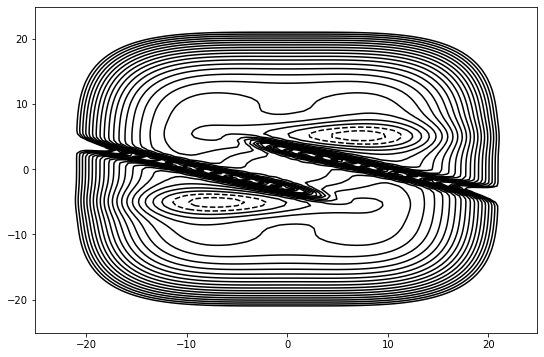

In [4]:
# defines potential energy landscape
# outer walls prevent the simulation to move past them by applying an exponential(?) potential
# Gaussian defines the two circular wells on the landscape

pes_Z = toys.ZPotential()
pes_H = toys.HarmonicOscillator([1.0, 1.0], [1.0, 1.0], [0.0, 0.0])
#pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
#       toys.Gaussian(-0.7, [7.5, 7.5], [-0.5, 0.0]) +
#       toys.Gaussian(-0.7, [7.5, 7.5], [0.5, 0.0]))

plot = ToyPlot()
# sets contour lines to user defined
plot.contour_range = np.arange(-1.5, 10.0, 0.5)
plot.add_pes(pes_Z)
plot.plot()

pass

In [5]:
topology_Z = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes_Z)
toy_engine_Z = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.2, temperature=1.0, gamma=2.5),
                              'n_frames_max': 50000,
                              'n_steps_per_frame': 1}, topology_Z)
template_Z = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                        engine=toy_engine_Z)
topology_H = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes_H)
toy_engine_H= toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.2, temperature=1.0, gamma=2.5),
                              'n_frames_max': 50000,
                              'n_steps_per_frame': 1}, topology_H)
template_H = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                        engine=toy_engine_H)

In [12]:
# feeds in a current snapshot into the engine
toy_engine_Z.current_snapshot = template_Z
paths.PathMover.engine = toy_engine_Z

toy_engine_H.current_snapshot = template_H
paths.PathMover.engine = toy_engine_H

In [8]:
def circle(snapshot, center):
    import math
    return math.sqrt((snapshot.xyz[0][0]-center[0])**2
                     + (snapshot.xyz[0][1]-center[1])**2)
def disk(snapshot, center):
    import math
    return (snapshot.xyz[0][0]-center[0])**2/16 + (snapshot.xyz[0][1]-center[1])**2
# turns the circle function into a collective variable
# from collectivevariable.py
opA = paths.CoordinateFunctionCV(name="opA", f=disk, center=[-7.2, -5.1])
opB = paths.CoordinateFunctionCV(name="opB", f=disk, center=[7.2, 5.1])

In [9]:
# defines the volumes of state A and B as range of the circle functions
# with the respective center defined before
# from volume.py
stateA = paths.CVDefinedVolume(opA, 0.0, 0.25).named("A")
stateB = paths.CVDefinedVolume(opB, 0.0, 0.25).named("B")

In [14]:
# generate trajectory that includes frame in both states
n = 100000
long_trajectory_Z = toy_engine_Z.generate_n_frames(n_frames = n_frames)
long_trajectory_H1 = toy_engine_H.generate_n_frames(n_frames = n)
long_trajectory_H2 = toy_engine_H.generate_n_frames(n_frames = 10000)

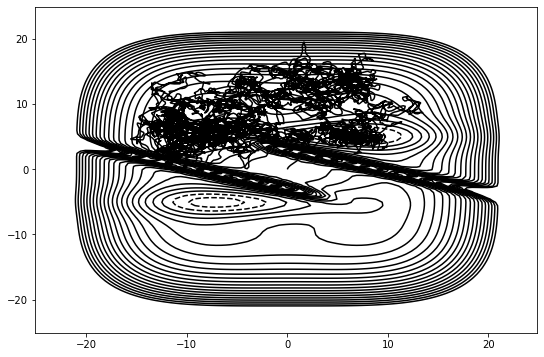

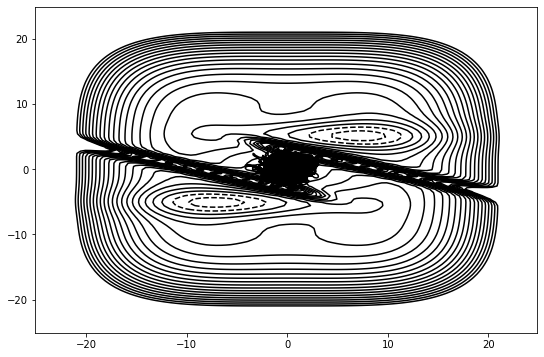

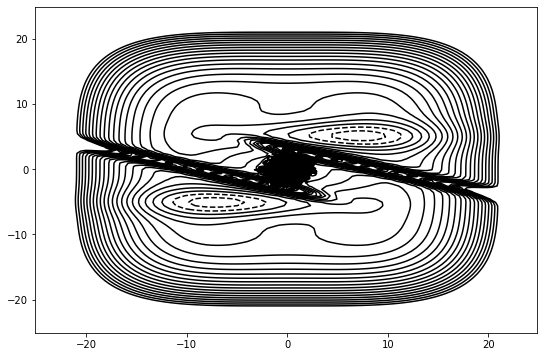

In [16]:
plot.plot([long_trajectory_Z])
plot.plot([long_trajectory_H1])
plot.plot([long_trajectory_H2])
#print(long_trajectory)
pass

In [26]:
# create a network so we can use its ensemble to obtain an initial trajectory
# use all-to-all because we don't care if initial traj is A->B or B->A: it can be reversed
AB_network = paths.TPSNetwork.from_states_all_to_all([stateA, stateB])
## take the subtrajectory matching the ensemble (only one ensemble, only one subtraj)


Ens_1InA = paths.IntersectionEnsemble(paths.AllInXEnsemble(stateA),paths.LengthEnsemble(1))
Ens_1InB = paths.IntersectionEnsemble(paths.AllInXEnsemble(stateB),paths.LengthEnsemble(1))
Ens_NotInAB = paths.IntersectionEnsemble(paths.AllOutXEnsemble(stateA), paths.AllOutXEnsemble(stateB))
AA_network = paths.SequentialEnsemble((Ens_1InA,Ens_NotInAB,Ens_1InA))
BB_network = paths.SequentialEnsemble((Ens_1InB,Ens_NotInAB,Ens_1InB))

print("Starting: AB")
subtrajectories_AB = []
for ens in AB_network.analysis_ensembles:
    subtrajectories_AB += ens.split(long_trajectory)
print("Starting: AA")
subtrajectories_AA = AA_network.split(long_trajectory)
print("Starting: BB")
subtrajectories_BB = BB_network.split(long_trajectory)
    
print(len(subtrajectories_AB))
print(len(subtrajectories_AA))
print(len(subtrajectories_BB))

Starting: AB
Starting: AA
Starting: BB
23
6041
5608


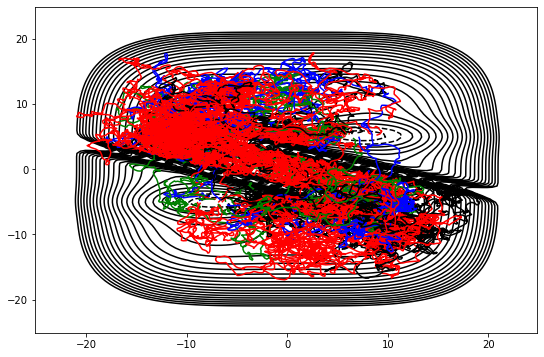

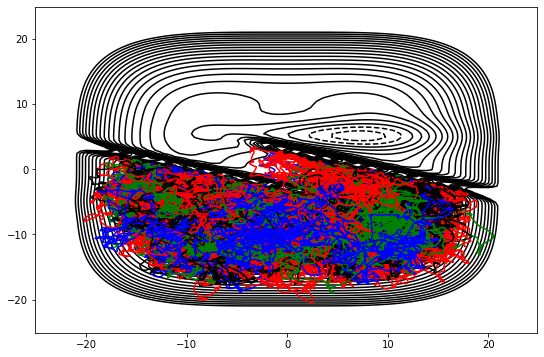

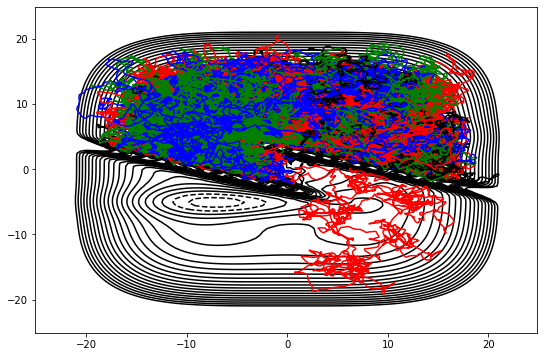

In [27]:
plot.plot(subtrajectories_AB)
plot.plot(subtrajectories_AA)
plot.plot(subtrajectories_BB)
pass

In [28]:
time_in_AA = sum([len(trajectory) for trajectory in subtrajectories_AA])
time_in_AB = sum([len(trajectory) for trajectory in subtrajectories_AB])
time_in_BB = sum([len(trajectory) for trajectory in subtrajectories_BB])
percentage_out_of_states = 100*sum([len(trajectory) for trajectory in subtrajectories_AA + subtrajectories_AB + subtrajectories_BB])/len(long_trajectory)

print("Simulation of {} steps was decomposed into:".format(len(long_trajectory)))
print("{} steps ({}%) spend in total outside of the stable states.".format(time_in_AA+time_in_AB+time_in_BB,percentage_out_of_states))
print("{} steps spend in AA trajectories.".format(time_in_AA))
print("{} steps spend in AB trajectories.".format(time_in_AB))
print("{} steps spend in AB trajectories.".format(time_in_BB))



Simulation of 1000000 steps was decomposed into:
957028 steps (95.7028%) spend in total outside of the stable states.
467645 steps spend in AA trajectories.
51608 steps spend in AB trajectories.
437775 steps spend in AB trajectories.


In [29]:
ADDITIONAL_DIMENSIONS = 8
# General structure of the "total_arrays": It's a three layered list list comprehension. 
# The inner layer generates an array of as many random number as dimensions are missing.
# The middle layer makes an array of subarrays, where each subarray constist of 
# the two actual values and the generated random number for each snapshot of a trajectory.
# The outer layer does this for each trajectory of the list of trajectories provided
# and appends all these arrays to one big list.

total_array_AA = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_AA])
total_array_AB = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_AB])
total_array_BB = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_BB])

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    snapshot_progress_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            snapshot_label_list.append(trajectory_label)
            # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
            # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
            # indicating a sucessfull transition a progress along the snapshots is calculated based on
            # the position within the trajectory and the total trajectory length.
            # For present/future lists, the offset needs to be taken into account in the denominator
            # If the dataset is a future variant of an offset trajectory list the progress label 
            # needs to additionally take the offset into account in the nominator.
            if trajectory_label == 0.0 or trajectory_label == 1.0:
                snapshot_progress_label_list.append(trajectory_label)
            else:
                if future == True:
                    snapshot_progress_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                else:
                    snapshot_progress_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list), np.array(snapshot_progress_label_list)

# generates the list of all trajectories and the coressponding labels by concatenation
trajectory_list = np.array([trajectory for trajectory in total_array_AA]
                                +[trajectory for trajectory in total_array_AB]
                                +[trajectory for trajectory in total_array_BB])
trajectory_label_list = np.array([0.0 for trajectory in total_array_AA]
                                      +[0.5 for trajectory in total_array_AB]
                                      +[1.0 for trajectory in total_array_BB])

#snapshot_list, snapshot_label_list, snapshot_progress_label_list = get_snapshot_and_label_list(
#    trajectory_list, trajectory_label_list)
print(trajectory_list.shape)
print(trajectory_label_list.shape)
#print(snapshot_list.shape)
#print(snapshot_label_list.shape)
#print(snapshot_progress_label_list.shape)


(11672,)
(11672,)


In [33]:
#OFFSET = 5
#def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
#    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
#    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
#    return present_trajectory_list, future_trajectory_list
#present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, OFFSET)

In [34]:
#present_snapshot_list, present_snapshot_label_list, present_snapshot_progress_label_list = get_snapshot_and_label_list(
#    present_trajectory_list, trajectory_label_list, OFFSET)
#future_snapshot_list, future_snapshot_label_list, future_snapshot_progress_label_list = get_snapshot_and_label_list(
#    future_trajectory_list, trajectory_label_list, OFFSET, future = True)

In [36]:
#print(snapshot_list)

[[-0.342  0.113 -0.935 ...  0.439 -0.419  0.216]
 [-0.332  0.118  0.344 ...  0.995 -0.478  0.624]
 [-0.324  0.122  0.108 ...  0.993  0.825  0.955]
 ...
 [ 0.382 -0.182 -0.26  ...  0.269 -0.139  0.453]
 [ 0.392 -0.175 -0.65  ... -0.71  -0.552  0.48 ]
 [ 0.401 -0.167  0.369 ...  0.709 -0.757  0.511]]


In [30]:
pickle.dump(trajectory_list, open("trajectory_list.p", "wb"))
pickle.dump(trajectory_label_list, open("trajectory_label_list.p", "wb"))
#pickle.dump(snapshot_list, open("snapshot_list.p", "wb"))
#pickle.dump(snapshot_label_list, open("snapshot_label_list.p", "wb"))
#pickle.dump(snapshot_progress_label_list, open("snapshot_progress_label_list.p", "wb"))

In [ ]:
TIME_STAMP = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))